Midtern - Image Processing <br>
Nguyen Van Truong - 22022571

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

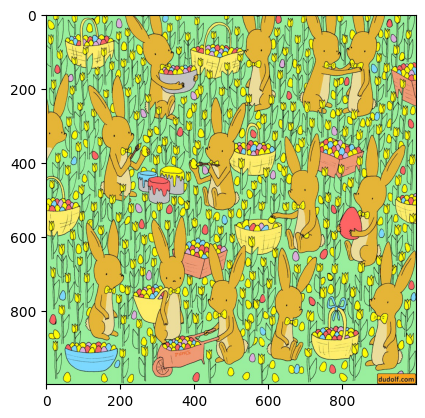

In [3]:
image = cv2.imread('Counting/rabbit.jpeg')
plt.imshow(image[:, :, ::-1])

# Helper Function


Ý tưởng ở đây là ta sẽ sử dụng hàm draw_square(), extract_image() để xác định template

In [4]:
def draw_square(image, points):
    image_with_square = image.copy()

    (x1, y1), (x2, y2) = points

    cv2.rectangle(image_with_square, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return image_with_square

def extract_image(image, points):
    (x1, y1), (x2, y2) = points
    roi = image[y1:y2, x1:x2]
    return roi

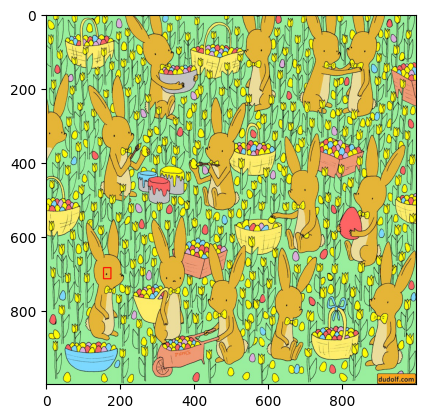

In [5]:
points = [(155, 685), (175, 715)]
image_with_square = draw_square(image, points)
plt.imshow(image_with_square[:, :, ::-1])

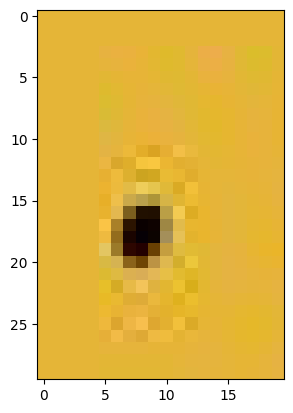

In [6]:
points = [(155, 685), (175, 715)]
split_img = extract_image(image, points)
plt.imshow(split_img[:, :, ::-1])

In [ ]:
def iou(u, v, shape):
    height, width = shape
    # kiem tra 2 diem co nam trong hinh khong
    if np.abs((u[0] - v[0])) > width or np.abs((u[1] - v[1])) > height:
        return 0
    else:
        i_width = width - np.abs((u[0] - v[0]))
        i_height = height - np.abs((u[1] - v[1]))
        return (i_width * i_height) / ((width * height) * 2 - (i_width * i_height)) #tinh IoU

def are_boxes_near(box1, box2, vicinity_threshold):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    center1_x = x1 + w1 / 2
    center1_y = y1 + h1 / 2
    center2_x = x2 + w2 / 2
    center2_y = y2 + h2 / 2

    distance = np.sqrt((center1_x - center2_x) ** 2 + (center1_y - center2_y) ** 2)

    return distance <= vicinity_threshold

Hàm iou(): Tính IoU để đo độ chồng lần giữa 2 vùng. <br>
Hàm are_boxes_near(): kiểm tra xem hai hộp (box1, box2) có nằm gần nhau hay không dựa trên một ngưỡng khoảng cách (vicinity_threshold).

# Counting


#### Ý tưởng ở đây là sử dụng đặc trưng chung của vật trong mỗi ảnh VD: mắt, mũi, màu,.... <br>
Sau đó thuật toán Template Matching sẽ sử dụng những đặc trưng này xác định các vật thể để đếm nó, ngoài ra em sử dụng thêm thuật toán IoU để loại bỏ những cặp ảnh trùng nhau và Handle Overlapping để giảm trùng lặp giữa các vùng phát hiện giúp tránh đếm sai số lượng vật thể

In [ ]:
class Counting:
    def __init__(self, points, path):
        self.points = points
        self.path = path

        self.image_viz = cv2.imread(path)
        self.obj_viz = extract_image(self.image_viz, points)

        self.image = cv2.imread(path)[:,:,2]
        cv2.imwrite('pic_roi.png', self.obj_viz)
        self.obj = cv2.imread('pic_roi.png')[:,:,2] #lay mau template
        self.locs = []
        self.bounding_boxes = []

    def visualize(self): # hien thi anh goc
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(self.image_viz, cv2.COLOR_BGR2RGB))

    def template_matching_algo(self, threshold=0.01, method=cv2.TM_SQDIFF_NORMED):
        img2 = self.image.copy()
        tem = self.obj.copy()

        # template matching
        result = cv2.matchTemplate(img2, tem, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        for i in range(result.shape[0]):
            for j in range(result.shape[1]):
                if result[i, j] < threshold:
                    self.locs.append((j, i))
        count = 1

    # Lọc bỏ vùng trùng lặp bằng IoU(Intersection over Union)
    def filter(self, show = True):
        final_des = []
        tem = self.obj

        print(f"Original locs (before filtering): {len(self.locs)} matches found.")

        for u in self.locs:
            if len(final_des) == 0:
                final_des.append(u)
            else:
                check = True
                for v in final_des:
                    overlap = iou(u, v, tem.shape)
                    if overlap > 0.5:
                        check = False
                if check:
                    final_des.append(u)

        print(f"Filtered locs (after IoU filtering): {len(final_des)} unique matches found.")
        # hiển thi kết quả lọc
        if show:
            count = 1
            img3 = cv2.imread(self.path)
            for loc in final_des:
                width = tem.shape[1]  # Template width
                height = tem.shape[0]  # Template height
                bottom_right = (loc[0] + tem.shape[1], loc[1] + tem.shape[0])
                self.bounding_boxes.append((loc[0], loc[1], width, height))
                cv2.rectangle(img3, loc, bottom_right, (0, 0, 255), 2)
                cv2.putText(img3, str(count), (loc[0], loc[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
                count += 1

            figure(figsize=(10, 10), dpi=80)
            plt.imshow(img3[:, :, ::-1])
            plt.show()

        else:
            for loc in final_des:
                width = tem.shape[1]
                height = tem.shape[0]
                bottom_right = (loc[0] + tem.shape[1], loc[1] + tem.shape[0])
                self.bounding_boxes.append((loc[0], loc[1], width, height))
    # Lọc bỏ vùng trùng lặp bằng khoảng cách giữa các bounding box
    def merge_overlap_boxes(self, vicinity_threshold = 50):

        grouped_boxes = []

        for box in self.bounding_boxes:
            found_group = False
            for group in grouped_boxes:
                if any(are_boxes_near(box, other_box, vicinity_threshold) for other_box in group):
                    group.append(box)
                    found_group = True
                    break
            if not found_group:
                grouped_boxes.append([box])

        merged_boxes = []
        for group in grouped_boxes:
            if len(group) == 1:
                merged_boxes.append(group[0])
            else:
                x_coords = [b[0] for b in group]
                y_coords = [b[1] for b in group]
                widths = [b[2] for b in group]
                heights = [b[3] for b in group]

                top_left_x = min(x_coords)
                top_left_y = min(y_coords)
                bottom_right_x = max([x + w for x, w in zip(x_coords, widths)])
                bottom_right_y = max([y + h for y, h in zip(y_coords, heights)])

                merged_width = bottom_right_x - top_left_x
                merged_height = bottom_right_y - top_left_y

                merged_boxes.append((top_left_x, top_left_y, merged_width, merged_height))

        image_copy = self.image_viz.copy()
        for box in merged_boxes:
            top_left = (box[0], box[1])
            bottom_right = (box[0] + box[2], box[1] + box[3])
            cv2.rectangle(image_copy, top_left, bottom_right, (0, 255, 0), 2)

        figure(figsize=(10, 10), dpi=80)
        plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
        plt.show()

filer(): Xóa các điểm trùng nhau bằng cách dùng IoU trên các vị trí khớp từ Template Matching. <br>
merge_overlap_boxes(): Gộp các bounding box gần nhau để tránh đếm trùng lặp khi đã có bounding box. 

### Image 1


Original locs (before filtering): 98 matches found.
Filtered locs (after IoU filtering): 14 unique matches found.


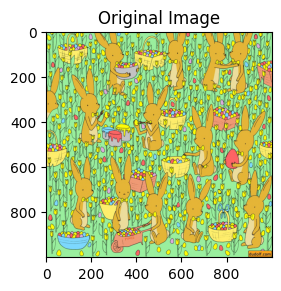

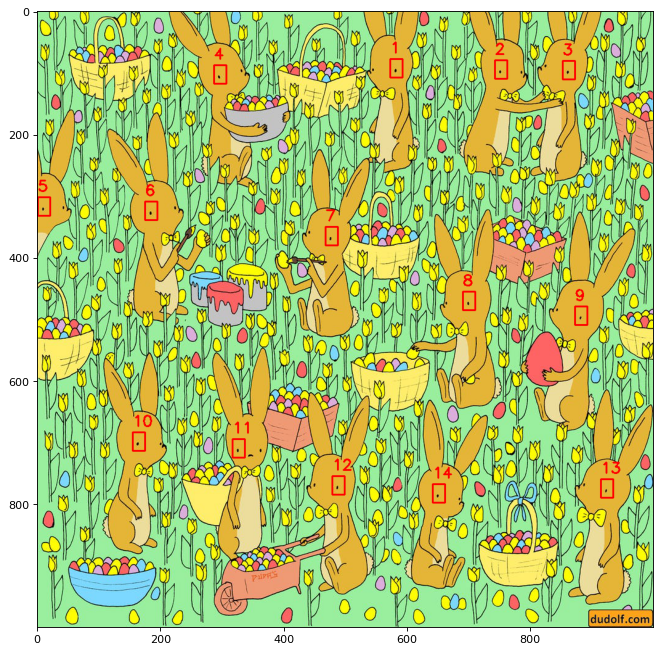

In [9]:
path = 'Counting/rabbit.jpeg'
points = [(155, 685), (175, 715)]

template_matching = Counting(points, path)

# Hiển thị ảnh và vùng ROI
template_matching.visualize()

# Thực hiện Template Matching
template_matching.template_matching_algo()
template_matching.filter()

### Image 2

Ảnh này ta sử dụng mũi để nhận diện, tuy nhiên mũi cũng có nhiều nhận dạng khác nhau dẫn tới ảnh hưởng đến việc counting. <br>
Để xử lý điều này ta cần lấy thêm nhiều nhận diện mũi hơn để tính toán.

Original locs (before filtering): 99 matches found.
Filtered locs (after IoU filtering): 32 unique matches found.


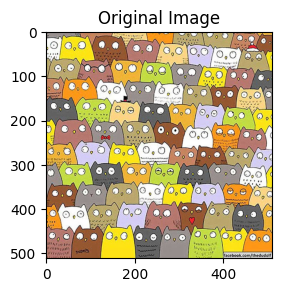

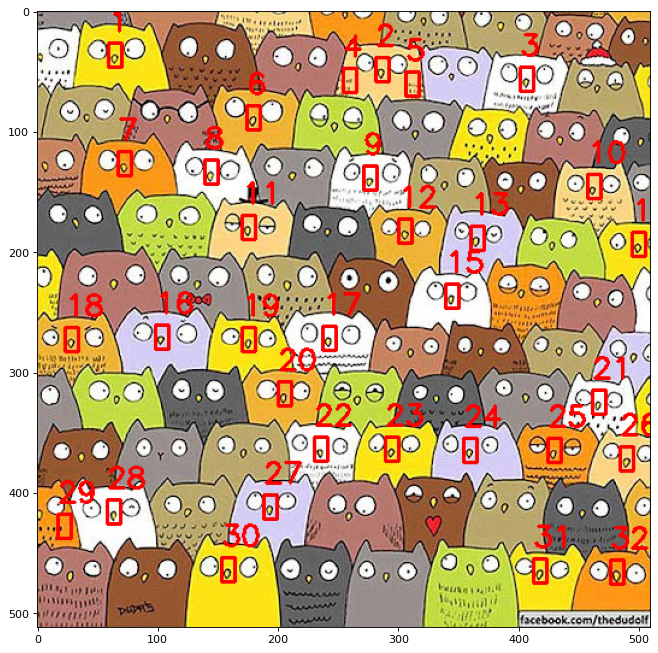

In [10]:
path = 'Counting/cat.jpg'
points = [(139, 125), (150, 145)]

template_matching = Counting(points, path)

template_matching.visualize()

template_matching.template_matching_algo(threshold = 0.043)
template_matching.filter()